# TechCabal Ewè Audio Translation

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import keras_tuner as kt

# Define the desired length for MFCCs (e.g., 100 time steps)
fixed_length = 100

# Step 1: Function to extract MFCCs from a single audio file
def extract_mfcc(file_path, n_mfcc=13, sr=16000):
    try:
        audio, sample_rate = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccs = mfccs.T
        mfccs_normalized = (mfccs - np.mean(mfccs, axis=0)) / np.std(mfccs, axis=0)
        mfccs_padded = pad_mfcc(mfccs_normalized, fixed_length)
        return mfccs_padded
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Step 2: Padding function
def pad_mfcc(mfcc, length=fixed_length):
    if mfcc.shape[0] < length:
        padded_mfcc = np.pad(mfcc, ((0, length - mfcc.shape[0]), (0, 0)), mode='constant')
    else:
        padded_mfcc = mfcc[:length, :]
    return padded_mfcc

# Step 3: Create an enhanced model with architecture improvements
def build_model(hp):
    model = tf.keras.models.Sequential()

    # First convolutional block with Batch Normalization and Max Pooling
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=(100, 13, 1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Second convolutional block with more filters
    model.add(tf.keras.layers.Conv2D(filters=filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Third convolutional block (deeper with more filters)
    model.add(tf.keras.layers.Conv2D(filters=filters * 4, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Fully connected layer with dropout
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(tf.keras.layers.Dense(units=units, activation='relu'))
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(dropout))

    # Output layer for classification
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    # Compile the model with tuned learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Step 4: Define hyperparameters and the tuner
hp = kt.HyperParameters()
hp.Int('filters', min_value=32, max_value=128, step=32)
hp.Int('units', min_value=64, max_value=256, step=64)
hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

# Create the tuner and disable new hyperparameter entries
tuner = kt.RandomSearch(
    build_model,
    hyperparameters=hp,
    objective='val_accuracy',
    max_trials=5,  # Try up to 5 hyperparameter combinations
    executions_per_trial=1,  # Run each trial once
    directory='my_dir',
    project_name='audio_cnn_tuning',
    allow_new_entries=False  # Ensure no new hyperparameters are added
)

# Example usage of the pipeline
audio_directory = './TechCabal Ewe Audio Files-20240921T072843Z-001/TechCabal Ewe Audio Files'
df = pd.read_csv('updated_dataset.csv')  # Load your dataset
audio_file_names = df['audio_file_name'].dropna().tolist()  # List of audio file names

# Step 5: Process and load the MFCCs
def audio_pipeline(audio_directory, audio_file_names):
    all_mfccs = []
    for filename in tqdm(audio_file_names, desc="Processing Audio Files", unit="file"):
        file_path = os.path.join(audio_directory, filename)
        mfccs = extract_mfcc(file_path)
        if mfccs is not None:
            all_mfccs.append(mfccs)
    return np.array(all_mfccs)

# Process and load MFCCs
all_mfccs_array = audio_pipeline(audio_directory, audio_file_names)

# Step 6: Extract labels and ensure correct shape
df_cleaned = df.dropna(subset=['audio_file_name'])
labels = df_cleaned['class'].tolist()

# One-hot encode the labels to match the 8 output classes
lb = LabelBinarizer()
y = lb.fit_transform(labels)

# Reshape MFCCs for CNN input (samples, time steps, MFCC coefficients, 1 channel)
X = all_mfccs_array.reshape(all_mfccs_array.shape[0], all_mfccs_array.shape[1], all_mfccs_array.shape[2], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Perform hyperparameter tuning inside a try-except block
try:
    tuner.search(X_train, y_train, epochs=15, validation_data=(X_test, y_test))
except Exception as e:
    print(f"Error during hyperparameter tuning: {e}")

# Step 8: Get the best model and train it
try:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete. 
    The optimal number of filters is {best_hps.get('filters')}, 
    the best units in dense layer is {best_hps.get('units')}, 
    the best dropout rate is {best_hps.get('dropout')}, 
    and the best learning rate is {best_hps.get('learning_rate')}.
    """)

    # Step 9: Train the best model
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

    # Step 10: Evaluate the best model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Step 11: Plot training/validation accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
except Exception as e:
    print(f"Error during model training or evaluation: {e}")


Reloading Tuner from my_dir\audio_cnn_tuning\tuner0.json


Processing Audio Files: 100%|███████████████████████████████████████████████████| 4587/4587 [00:43<00:00, 106.39file/s]



Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
64                |96                |filters
5                 |3                 |kernel_size
5                 |3                 |kernel_size_2
128               |256               |units
0.4               |0.2               |dropout
0.00014299        |0.0012623         |learning_rate

Error during hyperparameter tuning: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C

Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
            ^

Trial 6 Complete [00h 02m 10s]
val_accuracy: 0.9967319965362549

Best val_accuracy So Far: 1.0
Total elapsed time: 23h 34m 17s

    The hyperparameter search is complete. 
    The optimal number of filters is 96, 
    the best units in dense layer is 256, 
    the best dropout rate is 0.2, 
    and the best learning rate is 0.0012622943687455564.
    
Epoch 1/15
115/115 [==============================] - 15s 119ms/step - loss: 0.9098 - accuracy: 0.7067 - val_loss: 5.0891 - val_accuracy: 0.1449
Epoch 2/15
115/115 [==============================] - 13s 116ms/step - loss: 0.2692 - accuracy: 0.9185 - val_loss: 9.4083 - val_accuracy: 0.1449
Epoch 3/15
115/115 [==============================] - 13s 113ms/step - loss: 0.1339 - accuracy: 0.9597 - val_loss: 8.5910 - val_accuracy: 0.1460
Epoch 4/15
115/115 [==============================] - 13s 114ms/step - loss: 0.0797 - accuracy: 0.9774 - val_loss: 6.1591 - val_accuracy: 0.2930
Epoch 5/15
115/115 [==============================] - 13s 114ms/st

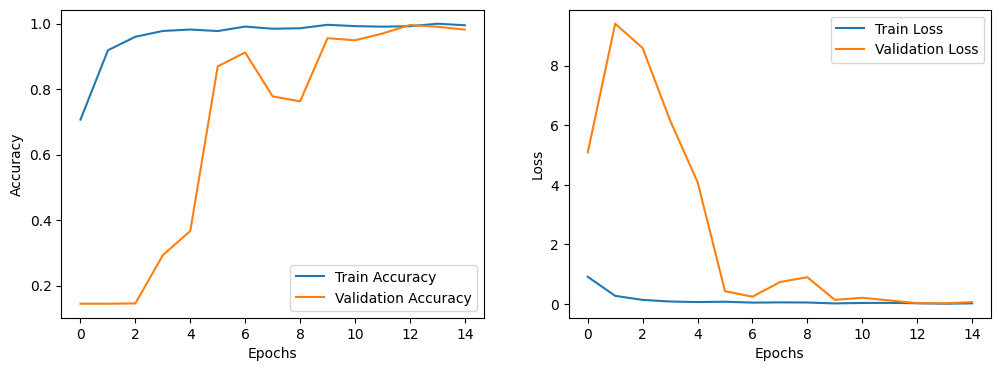

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import keras_tuner as kt

# Define the desired length for MFCCs (e.g., 128 time steps)
fixed_length = 128

# Step 1: Function to extract MFCCs from a single audio file
def extract_mfcc(file_path, n_mfcc=13, sr=16000):
    try:
        audio, sample_rate = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccs = mfccs.T
        mfccs_normalized = (mfccs - np.mean(mfccs, axis=0)) / np.std(mfccs, axis=0)
        mfccs_padded = pad_mfcc(mfccs_normalized, fixed_length)
        return mfccs_padded
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Step 2: Padding function
def pad_mfcc(mfcc, length=fixed_length):
    if mfcc.shape[0] < length:
        padded_mfcc = np.pad(mfcc, ((0, length - mfcc.shape[0]), (0, 0)), mode='constant')
    else:
        padded_mfcc = mfcc[:length, :]
    return padded_mfcc

# Step 3: Create an enhanced model with architecture improvements
def build_model(hp):
    model = tf.keras.models.Sequential()

    # First convolutional block with Batch Normalization and Max Pooling
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=(128, 13, 1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Second convolutional block with more filters
    model.add(tf.keras.layers.Conv2D(filters=filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Third convolutional block (use 1x1 kernel to avoid reducing spatial dimensions further)
    model.add(tf.keras.layers.Conv2D(filters=filters * 4, kernel_size=(1, 1), activation='relu'))  # Use 1x1 kernel
    model.add(tf.keras.layers.BatchNormalization())

    # Global Average Pooling
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Fully connected layer with dropout
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(tf.keras.layers.Dense(units=units, activation='relu'))
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(dropout))

    # Output layer for classification
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    # Compile the model with tuned learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Step 4: Define hyperparameters and the tuner
hp = kt.HyperParameters()
hp.Int('filters', min_value=32, max_value=128, step=32)
hp.Int('units', min_value=64, max_value=256, step=64)
hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

# Create the tuner and disable new hyperparameter entries
tuner = kt.RandomSearch(
    build_model,
    hyperparameters=hp,
    objective='val_accuracy',
    max_trials=5,  # Try up to 5 hyperparameter combinations
    executions_per_trial=1,  # Run each trial once
    directory='my_dir',
    project_name='audio_cnn_tuning',
    allow_new_entries=False  # Ensure no new hyperparameters are added
)

# Example usage of the pipeline
audio_directory = './TechCabal Ewe Audio Files-20240921T072843Z-001/TechCabal Ewe Audio Files'
df = pd.read_csv('updated_dataset.csv')  # Load your dataset
audio_file_names = df['audio_file_name'].dropna().tolist()  # List of audio file names

# Step 5: Process and load the MFCCs
def audio_pipeline(audio_directory, audio_file_names):
    all_mfccs = []
    for filename in tqdm(audio_file_names, desc="Processing Audio Files", unit="file"):
        file_path = os.path.join(audio_directory, filename)
        mfccs = extract_mfcc(file_path)
        if mfccs is not None:
            all_mfccs.append(mfccs)
    return np.array(all_mfccs)

# Process and load MFCCs
all_mfccs_array = audio_pipeline(audio_directory, audio_file_names)

# Step 6: Extract labels and ensure correct shape
df_cleaned = df.dropna(subset=['audio_file_name'])
labels = df_cleaned['class'].tolist()

# One-hot encode the labels to match the 8 output classes
lb = LabelBinarizer()
y = lb.fit_transform(labels)

# Reshape MFCCs for CNN input (samples, time steps, MFCC coefficients, 1 channel)
X = all_mfccs_array.reshape(all_mfccs_array.shape[0], all_mfccs_array.shape[1], all_mfccs_array.shape[2], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Perform hyperparameter tuning inside a try-except block
try:
    tuner.search(X_train, y_train, epochs=15, validation_data=(X_test, y_test))
except Exception as e:
    print(f"Error during hyperparameter tuning: {e}")

# Step 8: Get the best model and train it
try:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete. 
    The optimal number of filters is {best_hps.get('filters')}, 
    the best units in dense layer is {best_hps.get('units')}, 
    the best dropout rate is {best_hps.get('dropout')}, 
    and the best learning rate is {best_hps.get('learning_rate')}.
    """)

    # Step 9: Train the best model
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

    # Step 10: Evaluate the best model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Step 11: Plot training/validation accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
except Exception as e:
    print(f"Error during model training or evaluation: {e}")


In [5]:
model.save('my_trained_model1.h5')  # This saves the model to the current directory

In [6]:
import joblib

# Step 7: Train the CNN model (as in your original code)
# Extract the labels
df_cleaned1 = df.dropna(subset=['audio_file_name'])
labels1 = df_cleaned1['class'].tolist()

# One-hot encode the labels
lb = LabelBinarizer()
y = lb.fit_transform(labels)

# Save the LabelBinarizer for future use
joblib.dump(lb, 'label_binarizer1.pkl')


['label_binarizer1.pkl']

In [7]:
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
import joblib

# Define the desired length for MFCCs (e.g., 100 time steps)
fixed_length = 100

# Step 1: Function to extract MFCCs from a single audio file
def extract_mfcc(file_path, n_mfcc=13, sr=16000):
    try:
        audio, sample_rate = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccs = mfccs.T
        mfccs_normalized = (mfccs - np.mean(mfccs, axis=0)) / np.std(mfccs, axis=0)
        mfccs_padded = pad_mfcc(mfccs_normalized, fixed_length)
        return mfccs_padded
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Step 2: Padding function
def pad_mfcc(mfcc, length=fixed_length):
    if mfcc.shape[0] < length:
        padded_mfcc = np.pad(mfcc, ((0, length - mfcc.shape[0]), (0, 0)), mode='constant')
    else:
        padded_mfcc = mfcc[:length, :]
    return padded_mfcc

# Step 3: Search for audio files across multiple directories
def find_audio_files(audio_file_names, dir1, dir2):
    found_files = []
    missing_files = []

    for filename in audio_file_names:
        file_path1 = os.path.join(dir1, filename)
        file_path2 = os.path.join(dir2, filename)

        # Check if the file exists in either of the directories
        if os.path.exists(file_path1):
            found_files.append(file_path1)
        elif os.path.exists(file_path2):
            found_files.append(file_path2)
        else:
            missing_files.append(filename)
    
    return found_files, missing_files

# Step 4: Process and predict using the found files
def process_and_predict(model, audio_file_paths, n_mfcc=13, sr=16000):
    predictions = []

    for file_path in tqdm(audio_file_paths, desc="Processing and predicting"):
        mfccs = extract_mfcc(file_path, n_mfcc=n_mfcc, sr=sr)
        if mfccs is not None:
            mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)  # Reshape for CNN input
            pred = model.predict(mfccs)
            pred_label = np.argmax(pred, axis=1)[0]
            predictions.append((os.path.basename(file_path), pred_label))
    
    return predictions

# Example: Using the trained model to make predictions on new files

# 1. Load your dataset which contains the audio file names
data1 = pd.read_csv('Test_1.csv')  # Ensure this has the correct audio file names and durations
audio_file_names = data1['audio_filepath'].dropna().tolist()  # List of audio file names

# 2. Search for audio files across two directories
dir1 = './TechCabal Ewe Audio Files-20240921T072843Z-001/TechCabal Ewe Audio Files'
dir2 = './TechCabal Ewe Audio Files-20240921T072843Z-002/TechCabal Ewe Audio Files'
found_files, missing_files = find_audio_files(audio_file_names, dir1, dir2)

# Print missing files if any
if missing_files:
    print(f"Missing audio files: {missing_files}")

# 3. Load the trained model
model = tf.keras.models.load_model('my_trained_model1.h5')

# 4. Predict class labels for the found audio files
predictions = process_and_predict(model, found_files)

# 5. Load the LabelBinarizer to map predictions to class names
lb = joblib.load('label_binarizer1.pkl')

# 6. Convert prediction indices to class names and remove the '.wav' extension from filenames
predicted_class_names = [(os.path.splitext(filename)[0], lb.classes_[pred_label]) for filename, pred_label in predictions]

# 7. Save predictions to CSV (remove .wav from file names)
df_predictions = pd.DataFrame(predicted_class_names, columns=['id', 'class'])
df_predictions.to_csv('predictions5.csv', index=False)
print("Predictions saved to 'predictions5.csv'")


Processing and predicting:   0%|                                                              | 0/2946 [00:00<?, ?it/s]


ValueError: in user code:

    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 128, 13, 1), found shape=(None, 100, 13, 1)
